# 03. Calibration Demo

Notebook demo tính năng calibration để hiệu chỉnh forecast khớp với actual DEL curves.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
from config import (CFG, SEGMENT_COLS, BUCKETS_CANON, BUCKETS_30P, BUCKETS_60P, BUCKETS_90P,
                    ABSORBING_BASE, MAX_MOB, DENOM_LEVEL, K_CLIP)
from data_io import load_parquet, validate_schema
from transitions import prepare_transitions, estimate_transition_matrices
from forecast import build_initial_vectors, forecast
from calibration import fit_del_curve_factors, apply_matrix_calibration
from metrics import compute_del_from_snapshot, compute_del_from_forecast, make_mixed_report

print(f'K_CLIP bounds: {K_CLIP}')

K_CLIP bounds: (0.5, 2.0)


## Step 1: Load Data and Run Basic Pipeline

In [3]:
# Load and prepare data
df = load_parquet('../Oct25.parquet')
df_trans = prepare_transitions(df, CFG, SEGMENT_COLS, BUCKETS_CANON, ABSORBING_BASE)

# Estimate transition matrices
segment_levels = [("GLOBAL", []), ("COARSE", [SEGMENT_COLS[0]] if SEGMENT_COLS else []), ("FULL", SEGMENT_COLS)]
prior_strengths = {"coarse": 100.0, "full": 50.0}

transitions_dict, transitions_long_df, meta_df = estimate_transition_matrices(
    df_trans, CFG, BUCKETS_CANON, segment_levels, MAX_MOB, "ead", 30, prior_strengths, None)

# Build initial vectors and forecast
df_init, denom_map = build_initial_vectors(df, CFG, BUCKETS_CANON, SEGMENT_COLS, DENOM_LEVEL)
forecast_df = forecast(df_init, transitions_dict, BUCKETS_CANON, MAX_MOB)

print(f"Data shape: {df.shape}")
print(f"Transitions: {df_trans.shape}")
print(f"Forecast: {forecast_df.shape}")

Loading parquet file: ..\Oct25.parquet
Data shape: (27514143, 14)
Transitions: (25628053, 7)
Forecast: (32725, 5)


## Step 2: Compute Actual vs Predicted DEL

In [4]:
# Compute actual DEL from snapshot
actual_del_long, actual_denom = compute_del_from_snapshot(
    df, CFG, BUCKETS_30P, SEGMENT_COLS, MAX_MOB, DENOM_LEVEL
)

# Compute predicted DEL from forecast
pred_del_long = compute_del_from_forecast(forecast_df, BUCKETS_30P, denom_map)

print(f"Actual DEL records: {len(actual_del_long)}")
print(f"Predicted DEL records: {len(pred_del_long)}")

# Preview
print("\nActual DEL sample:")
display(actual_del_long.head())

print("\nPredicted DEL sample:")
display(pred_del_long.head())

Actual DEL records: 2903
Predicted DEL records: 4675

Actual DEL sample:


,cohort,segment_key,mob,del_pct,denom_ead,numer_ead
0,2023-01,CDLPIL,0,0.000000,608844.739598,0.000000
1,2023-01,CDLPIL,1,0.000123,608844.739598,74.757900
2,2023-01,CDLPIL,2,0.002020,608844.739598,1230.145623
3,2023-01,CDLPIL,3,0.004359,608844.739598,2654.120661
4,2023-01,CDLPIL,4,0.005703,608844.739598,3472.161378



Predicted DEL sample:


,cohort,segment_key,mob,del_pct,denom_ead,numer_ead
0,2023-01,CDLPIL,0,0.000000,608844.739598,0.000000
1,2023-01,CDLPIL,1,0.000106,608844.739598,64.701761
2,2023-01,CDLPIL,2,0.004027,608844.739598,2451.774551
3,2023-01,CDLPIL,3,0.010131,608844.739598,6168.248993
4,2023-01,CDLPIL,4,0.016671,608844.739598,10149.987787


## Step 3: Fit Calibration Factors

Calibration Factors by MOB:


,mob,k,n_cohorts_used,pred_mean,actual_mean
0,0,1.000000,187,0.000000,0.000000
1,1,1.012436,181,0.000247,0.000250
2,2,1.038535,175,0.003708,0.003851
3,3,1.013142,169,0.008531,0.008643
4,4,0.981858,163,0.013360,0.013118
5,5,0.926027,157,0.020137,0.018648
6,6,0.889396,151,0.025482,0.022663
7,7,0.865475,145,0.029800,0.025791
8,8,0.843565,139,0.033559,0.028309
9,9,0.827276,133,0.037027,0.030631


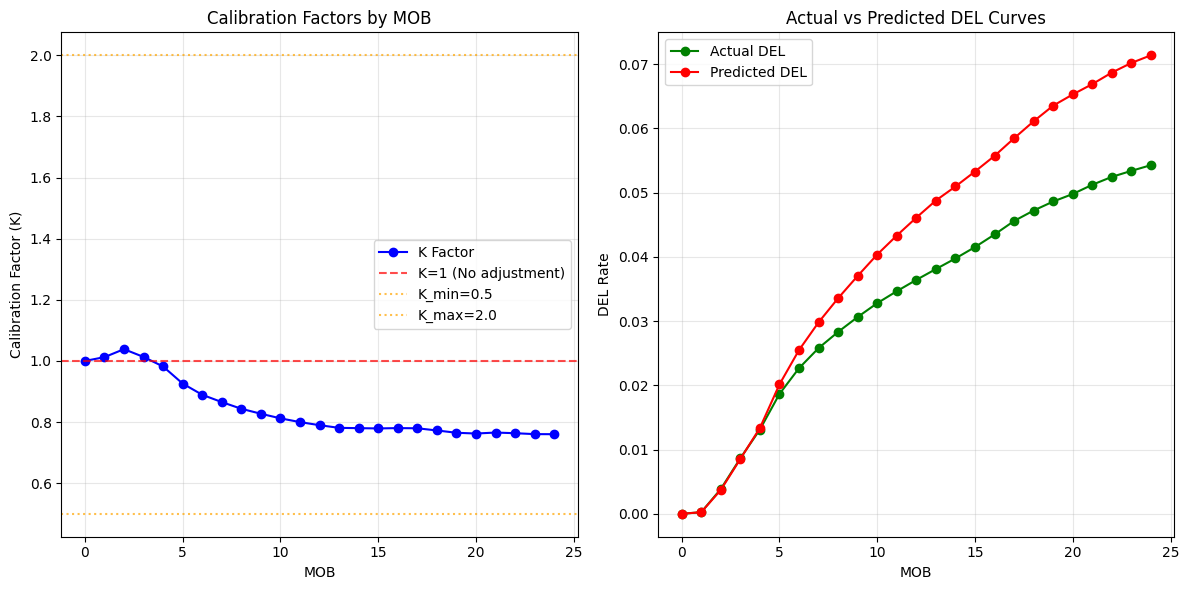

In [5]:
# Fit calibration factors
factors_df = fit_del_curve_factors(actual_del_long, pred_del_long, MAX_MOB, K_CLIP)

print("Calibration Factors by MOB:")
display(factors_df)

# Plot calibration factors
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(factors_df['mob'], factors_df['k'], 'bo-', label='K Factor')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='K=1 (No adjustment)')
plt.axhline(y=K_CLIP[0], color='orange', linestyle=':', alpha=0.7, label=f'K_min={K_CLIP[0]}')
plt.axhline(y=K_CLIP[1], color='orange', linestyle=':', alpha=0.7, label=f'K_max={K_CLIP[1]}')
plt.xlabel('MOB')
plt.ylabel('Calibration Factor (K)')
plt.title('Calibration Factors by MOB')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(factors_df['mob'], factors_df['actual_mean'], 'go-', label='Actual DEL')
plt.plot(factors_df['mob'], factors_df['pred_mean'], 'ro-', label='Predicted DEL')
plt.xlabel('MOB')
plt.ylabel('DEL Rate')
plt.title('Actual vs Predicted DEL Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Apply Calibration to Transition Matrices

In [6]:
# Apply calibration to all transition matrices
transitions_dict_calibrated = {}

print("Applying calibration to transition matrices...")
for key, matrix in transitions_dict.items():
    level, segment_key, mob = key
    
    # Get calibration factor for this MOB
    k_factor = factors_df[factors_df['mob'] == mob]['k'].iloc[0] if mob < len(factors_df) else 1.0
    
    # Apply calibration
    calibrated_matrix = apply_matrix_calibration(
        matrix, BUCKETS_30P, k_factor, ABSORBING_BASE
    )
    
    transitions_dict_calibrated[key] = calibrated_matrix

print(f"Calibrated {len(transitions_dict_calibrated)} matrices")

# Compare one matrix before/after calibration
sample_key = list(transitions_dict.keys())[0]
level, segment_key, mob = sample_key
k_factor = factors_df[factors_df['mob'] == mob]['k'].iloc[0]

print(f"\nSample Matrix Comparison (Level: {level}, Segment: {segment_key}, MOB: {mob}, K: {k_factor:.3f})")
print("\nOriginal Matrix:")
display(transitions_dict[sample_key].round(4))

print("\nCalibrated Matrix:")
display(transitions_dict_calibrated[sample_key].round(4))

Applying calibration to transition matrices...
Calibrated 298 matrices

Sample Matrix Comparison (Level: GLOBAL, Segment: , MOB: 0, K: 1.000)

Original Matrix:


,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,WRITEOFF,PREPAY
DPD0,0.9644,0.0257,0.0000,0.0,0.0,0.0,0.0099
DPD1+,0.2128,0.2842,0.4987,0.0,0.0,0.0,0.0043
DPD30+,0.0000,0.0000,1.0000,0.0,0.0,0.0,0.0000
DPD60+,0.0000,0.0000,0.0000,1.0,0.0,0.0,0.0000
DPD90+,0.0000,0.0000,0.0000,0.0,1.0,0.0,0.0000
WRITEOFF,0.0000,0.0000,0.0000,0.0,0.0,1.0,0.0000
PREPAY,0.0000,0.0000,0.0000,0.0,0.0,0.0,1.0000



Calibrated Matrix:


,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,WRITEOFF,PREPAY
DPD0,0.9644,0.0257,0.0000,0.0,0.0,0.0,0.0099
DPD1+,0.2128,0.2842,0.4987,0.0,0.0,0.0,0.0043
DPD30+,0.0000,0.0000,1.0000,0.0,0.0,0.0,0.0000
DPD60+,0.0000,0.0000,0.0000,1.0,0.0,0.0,0.0000
DPD90+,0.0000,0.0000,0.0000,0.0,1.0,0.0,0.0000
WRITEOFF,0.0000,0.0000,0.0000,0.0,0.0,1.0,0.0000
PREPAY,0.0000,0.0000,0.0000,0.0,0.0,0.0,1.0000


## Step 5: Re-forecast with Calibrated Matrices

In [7]:
# Re-forecast with calibrated matrices
forecast_df_calibrated = forecast(df_init, transitions_dict_calibrated, BUCKETS_CANON, MAX_MOB)

# Compute calibrated predicted DEL
pred_del_long_calibrated = compute_del_from_forecast(forecast_df_calibrated, BUCKETS_30P, denom_map)

print(f"Calibrated forecast shape: {forecast_df_calibrated.shape}")
print(f"Calibrated predicted DEL records: {len(pred_del_long_calibrated)}")

Calibrated forecast shape: (32725, 5)
Calibrated predicted DEL records: 4675


## Step 6: Compare Results

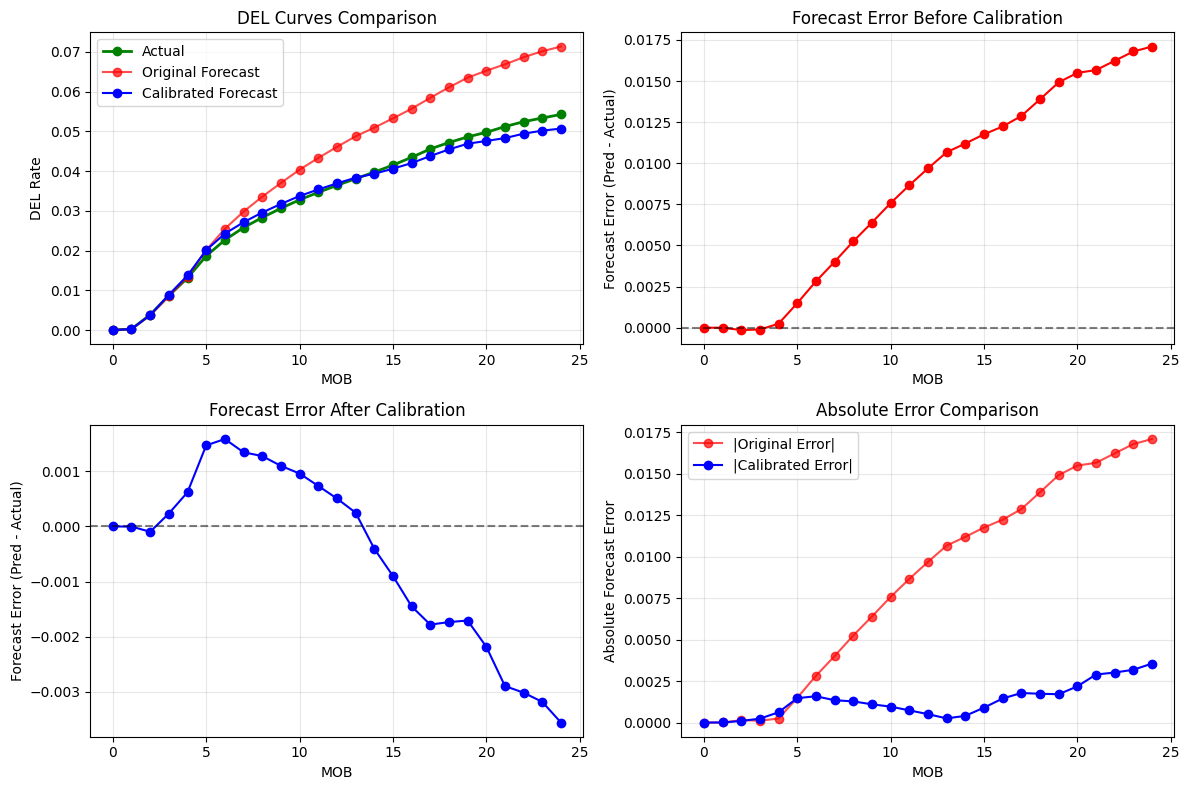


=== CALIBRATION SUMMARY ===
Original MAE: 0.0086
Calibrated MAE: 0.0013
MAE Improvement: 84.7%


In [8]:
# Aggregate DEL by MOB for comparison
actual_agg = actual_del_long.groupby('mob')['del_pct'].mean().reset_index()
pred_agg = pred_del_long.groupby('mob')['del_pct'].mean().reset_index()
pred_calib_agg = pred_del_long_calibrated.groupby('mob')['del_pct'].mean().reset_index()

# Plot comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(actual_agg['mob'], actual_agg['del_pct'], 'go-', label='Actual', linewidth=2)
plt.plot(pred_agg['mob'], pred_agg['del_pct'], 'ro-', label='Original Forecast', alpha=0.7)
plt.plot(pred_calib_agg['mob'], pred_calib_agg['del_pct'], 'bo-', label='Calibrated Forecast')
plt.xlabel('MOB')
plt.ylabel('DEL Rate')
plt.title('DEL Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
# Error before calibration
merged_orig = actual_agg.merge(pred_agg, on='mob', suffixes=('_actual', '_pred'))
merged_orig['error'] = merged_orig['del_pct_pred'] - merged_orig['del_pct_actual']

plt.plot(merged_orig['mob'], merged_orig['error'], 'ro-', label='Original Error')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('MOB')
plt.ylabel('Forecast Error (Pred - Actual)')
plt.title('Forecast Error Before Calibration')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
# Error after calibration
merged_calib = actual_agg.merge(pred_calib_agg, on='mob', suffixes=('_actual', '_pred'))
merged_calib['error'] = merged_calib['del_pct_pred'] - merged_calib['del_pct_actual']

plt.plot(merged_calib['mob'], merged_calib['error'], 'bo-', label='Calibrated Error')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('MOB')
plt.ylabel('Forecast Error (Pred - Actual)')
plt.title('Forecast Error After Calibration')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Error comparison
plt.plot(merged_orig['mob'], np.abs(merged_orig['error']), 'ro-', label='|Original Error|', alpha=0.7)
plt.plot(merged_calib['mob'], np.abs(merged_calib['error']), 'bo-', label='|Calibrated Error|')
plt.xlabel('MOB')
plt.ylabel('Absolute Forecast Error')
plt.title('Absolute Error Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
orig_mae = np.mean(np.abs(merged_orig['error']))
calib_mae = np.mean(np.abs(merged_calib['error']))

print(f"\n=== CALIBRATION SUMMARY ===")
print(f"Original MAE: {orig_mae:.4f}")
print(f"Calibrated MAE: {calib_mae:.4f}")
print(f"MAE Improvement: {((orig_mae - calib_mae) / orig_mae * 100):.1f}%")

## Step 7: Create Mixed Reports

In [9]:
# Create mixed reports for both original and calibrated
mixed_orig, flags_orig, actual_wide, forecast_orig = make_mixed_report(
    actual_del_long, pred_del_long, MAX_MOB
)

mixed_calib, flags_calib, _, forecast_calib = make_mixed_report(
    actual_del_long, pred_del_long_calibrated, MAX_MOB
)

print("Mixed Report Shapes:")
print(f"Original Mixed: {mixed_orig.shape}")
print(f"Calibrated Mixed: {mixed_calib.shape}")

# Sample comparison
sample_idx = 0
print(f"\nSample Row {sample_idx} Comparison:")
print("\nOriginal Mixed:")
display(mixed_orig.iloc[[sample_idx]])

print("\nCalibrated Mixed:")
display(mixed_calib.iloc[[sample_idx]])

print("\nFlags (same for both):")
display(flags_orig.iloc[[sample_idx]])

Mixed Report Shapes:
Original Mixed: (187, 27)
Calibrated Mixed: (187, 27)

Sample Row 0 Comparison:

Original Mixed:


,cohort,segment_key,MOB_0,MOB_1,MOB_2,MOB_3,MOB_4,MOB_5,MOB_6,MOB_7,...,MOB_15,MOB_16,MOB_17,MOB_18,MOB_19,MOB_20,MOB_21,MOB_22,MOB_23,MOB_24
0,2023-01,CDLPIL,0.0,0.000123,0.00202,0.004359,0.005703,0.00795,0.009489,0.010242,...,0.010129,0.010166,0.010296,0.010429,0.01045,0.010476,0.010575,0.010585,0.010511,0.010478



Calibrated Mixed:


,cohort,segment_key,MOB_0,MOB_1,MOB_2,MOB_3,MOB_4,MOB_5,MOB_6,MOB_7,...,MOB_15,MOB_16,MOB_17,MOB_18,MOB_19,MOB_20,MOB_21,MOB_22,MOB_23,MOB_24
0,2023-01,CDLPIL,0.0,0.000123,0.00202,0.004359,0.005703,0.00795,0.009489,0.010242,...,0.010129,0.010166,0.010296,0.010429,0.01045,0.010476,0.010575,0.010585,0.010511,0.010478



Flags (same for both):


,cohort,segment_key,MOB_0,MOB_1,MOB_2,MOB_3,MOB_4,MOB_5,MOB_6,MOB_7,...,MOB_15,MOB_16,MOB_17,MOB_18,MOB_19,MOB_20,MOB_21,MOB_22,MOB_23,MOB_24
0,2023-01,CDLPIL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,...,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL,ACTUAL


## Usage Guide

### Cách sử dụng Calibration:

1. **Bật/tắt calibration**: Thay đổi `ENABLE_CALIBRATION = True/False` trong notebook chính

2. **Điều chỉnh K_CLIP**: Sửa trong `config.py`:
   ```python
   K_CLIP = (0.5, 2.0)  # (k_min, k_max)
   ```

3. **CLI usage**:
   ```bash
   python main.py --input data.parquet --output report.xlsx --calibrate
   ```

4. **Khi nào nên dùng calibration**:
   - Forecast DEL khác biệt đáng kể so với actual
   - Cần điều chỉnh forecast để khớp với observed patterns
   - Có đủ actual data để tính reliable calibration factors

5. **Lưu ý**:
   - Calibration chỉ điều chỉnh forecast, không thay đổi actual
   - K factors được clip trong khoảng [k_min, k_max] để tránh extreme adjustments
   - Calibration áp dụng cho bad states (BUCKETS_30P) trong transition matrices

## Step 8: Export Reports

In [10]:
# Import export functions
from metrics import compute_all_del_metrics
from export import export_all_del_to_excel
from forecast import merge_forecast_to_snapshot
import os

print("=== EXPORTING CALIBRATION REPORTS ===")
os.makedirs('../out', exist_ok=True)

=== EXPORTING CALIBRATION REPORTS ===


In [11]:
# Compute all DEL metrics for both original and calibrated
print("Computing DEL metrics for original forecast...")
del_results_orig = compute_all_del_metrics(
    df, forecast_df, CFG, SEGMENT_COLS, MAX_MOB, DENOM_LEVEL,
    BUCKETS_30P, BUCKETS_60P, BUCKETS_90P
)

print("Computing DEL metrics for calibrated forecast...")
del_results_calib = compute_all_del_metrics(
    df, forecast_df_calibrated, CFG, SEGMENT_COLS, MAX_MOB, DENOM_LEVEL,
    BUCKETS_30P, BUCKETS_60P, BUCKETS_90P
)

print("\nDEL results computed:")
for k in del_results_orig.keys():
    print(f"- {k}: Original {del_results_orig[k][0].shape}, Calibrated {del_results_calib[k][0].shape}")

Computing DEL metrics for original forecast...
Computing DEL metrics for calibrated forecast...

DEL results computed:
- DEL30: Original (187, 27), Calibrated (187, 27)
- DEL60: Original (187, 27), Calibrated (187, 27)
- DEL90: Original (187, 27), Calibrated (187, 27)


In [12]:
# Export original forecast report
print("\nExporting original forecast report...")
export_all_del_to_excel(
    '../out/calibration_demo_original.xlsx',
    transitions_long_df,
    del_results_orig,
    forecast_df=forecast_df,
    meta_df=meta_df
)
print("✓ Exported: calibration_demo_original.xlsx")

# Export calibrated forecast report
print("\nExporting calibrated forecast report...")
export_all_del_to_excel(
    '../out/calibration_demo_calibrated.xlsx',
    transitions_long_df,
    del_results_calib,
    forecast_df=forecast_df_calibrated,
    meta_df=meta_df,
    factors_df=factors_df
)
print("✓ Exported: calibration_demo_calibrated.xlsx")


Exporting original forecast report...


c:\Users\User\Projection_kiro\notebooks\..\export.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_flags = flags_wide.groupby("cohort").apply(agg_flags).reset_index()
c:\Users\User\Projection_kiro\notebooks\..\export.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_flags = flags_wide.groupby("cohort").apply(agg_flags).reset_index()
c:\Users\User\Projection_kiro\notebooks\..\export.py:72: F

✓ Exported: calibration_demo_original.xlsx

Exporting calibrated forecast report...


c:\Users\User\Projection_kiro\notebooks\..\export.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_flags = flags_wide.groupby("cohort").apply(agg_flags).reset_index()
c:\Users\User\Projection_kiro\notebooks\..\export.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_flags = flags_wide.groupby("cohort").apply(agg_flags).reset_index()
c:\Users\User\Projection_kiro\notebooks\..\export.py:72: F

✓ Exported: calibration_demo_calibrated.xlsx


In [13]:
# Export loan-level data with calibrated forecast
print("\nExporting loan-level data with calibrated forecast...")

# Merge calibrated forecast to original data
df_with_calib_forecast = merge_forecast_to_snapshot(
    df, forecast_df_calibrated, CFG, SEGMENT_COLS, BUCKETS_CANON,
    bad_states_30p=BUCKETS_30P,
    bad_states_60p=BUCKETS_60P,
    bad_states_90p=BUCKETS_90P
)

# Export to parquet
df_with_calib_forecast.to_parquet('../out/data_with_calibrated_forecast.parquet', index=False)
print("✓ Exported: data_with_calibrated_forecast.parquet")

print(f"Shape: {df_with_calib_forecast.shape}")
print("Forecast columns:", [c for c in df_with_calib_forecast.columns if 'forecast' in c])


Exporting loan-level data with calibrated forecast...


c:\Users\User\Projection_kiro\notebooks\..\forecast.py:350: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fct_agg = forecast_df.groupby(["cohort", "segment_key", "mob"]).apply(


KeyError: 'loan_id'

In [ ]:
# Export calibration factors and comparison data
print("\nExporting calibration analysis data...")

# Save calibration factors
factors_df.to_csv('../out/calibration_factors.csv', index=False)
print("✓ Exported: calibration_factors.csv")

# Save comparison data
comparison_data = {
    'actual_del': actual_del_long,
    'pred_del_original': pred_del_long,
    'pred_del_calibrated': pred_del_long_calibrated
}

for name, data in comparison_data.items():
    data.to_csv(f'../out/{name}.csv', index=False)
    print(f"✓ Exported: {name}.csv")

# Summary statistics
summary_stats = pd.DataFrame({
    'metric': ['Original MAE', 'Calibrated MAE', 'MAE Improvement %'],
    'value': [orig_mae, calib_mae, ((orig_mae - calib_mae) / orig_mae * 100)]
})
summary_stats.to_csv('../out/calibration_summary.csv', index=False)
print("✓ Exported: calibration_summary.csv")

In [ ]:
# Final summary
print("\n" + "="*50)
print("CALIBRATION DEMO EXPORT SUMMARY")
print("="*50)
print("\n📊 Excel Reports:")
print("  • calibration_demo_original.xlsx - Original forecast with DEL30/60/90")
print("  • calibration_demo_calibrated.xlsx - Calibrated forecast with DEL30/60/90")

print("\n📋 Data Files:")
print("  • data_with_calibrated_forecast.parquet - Loan-level data with calibrated DEL forecasts")
print("  • calibration_factors.csv - K factors by MOB")
print("  • actual_del.csv - Actual DEL data")
print("  • pred_del_original.csv - Original predicted DEL")
print("  • pred_del_calibrated.csv - Calibrated predicted DEL")
print("  • calibration_summary.csv - MAE comparison statistics")

print("\n📈 Key Results:")
print(f"  • Original MAE: {orig_mae:.4f}")
print(f"  • Calibrated MAE: {calib_mae:.4f}")
print(f"  • Improvement: {((orig_mae - calib_mae) / orig_mae * 100):.1f}%")
print(f"  • K factors range: {factors_df['k'].min():.2f} - {factors_df['k'].max():.2f}")

print("\n✅ All calibration demo reports exported successfully!")

## Export Files Description

### Excel Reports:
- **`calibration_demo_original.xlsx`**: Complete report with original forecast
  - Portfolio + per-product sheets for DEL30/60/90
  - Mixed (actual + forecast), Actual, Forecast, Flags sheets
  - Transition matrices, metadata

- **`calibration_demo_calibrated.xlsx`**: Complete report with calibrated forecast
  - Same structure as original but with calibrated values
  - Includes calibration_factors sheet

### Data Files:
- **`data_with_calibrated_forecast.parquet`**: Original data + calibrated DEL forecasts per loan
- **`calibration_factors.csv`**: K factors by MOB for analysis
- **`actual_del.csv`**: Actual DEL data for validation
- **`pred_del_original.csv`**: Original predicted DEL
- **`pred_del_calibrated.csv`**: Calibrated predicted DEL
- **`calibration_summary.csv`**: MAE improvement statistics

### Usage:
1. Compare Excel reports to see calibration impact
2. Use parquet file for further loan-level analysis
3. Analyze CSV files for calibration effectiveness
4. Use factors for applying same calibration to new data